In [1]:
%pwd

'/Users/seoseondeok/study/ESG_AI'

In [2]:
import os
import cv2
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# GPU 설정 및 사용 가능 체크
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU is available")
else:
    print("GPU is not available, using CPU")

GPU is available


In [17]:
# 그래픽카드 관련
import gc
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()
        print("GPU memory was cleaned!")

In [5]:
def load_and_preprocess_data(base_dir, img_size=(299, 299)):
    images = [] # image data를 모으는 빈 리스트 생성
    labels = [] # image data의 label(class)를 저장할 리스트 생성
    categories = ['NORMAL', 'PNEUMONIA']  # 카테고리 종류

    for category in categories: # NORMAL, PENUMONIA
        class_num = categories.index(category)  # Normal: 0, Penumonia: 1
        base_path = os.path.join(base_dir, category)  # 데이터 구조:
        base_files = os.listdir(base_path)  # train폴더에서 category에 맞는 데이터 받아옴
        np.random.shuffle(base_files) # 데이터를 랜덤하게 섞음

        for idx in range(500):  # 각 카테고리 별 500장씩 받아옴
          image_path = os.path.join(base_path, base_files[idx]) #
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # grayscale로 이미지 데이터 받아오기
          image = cv2.resize(image, img_size) # 이미지 사이즈 299x299로 resize
          images.append(image)  # 'NORMAL' 500장, 'PNEUMONIA' 500장
          labels.append(class_num)

    # -1: 개수만큼 다 집어넣으라는 의미
    # 이미지 사이즈
    # grayscale: 1  영상 데이터에서 grayscale의 채널 입력값은 1, rgb라면 3
    # images = np.array(images).reshape(-1, 이미지 사이즈, 채널 입력값)
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    return images, np.array(labels) # 리스트 데이터를

def split_data(X, y, test_size=0.2, val_size=0.5):
    X_train, X_val_test, y_train, y_val_test = train_test_split(X,  # image data
                                                                y,  # label data
                                                                test_size=test_size, # X_train, y_train에 80%의 데이터 입력
                                                                stratify=y,  # normal, pneumonia 클래스의 비율을 맞춰서 분할하기 위함
                                                                random_state=42)  # 랜덤시드 설정
    X_val, X_test, y_val, y_test = train_test_split(X_val_test,
                                                    y_val_test,
                                                    test_size=val_size,  # 남은 20% 데이터를 1/2로 나눔 -> val:test = 1:1 (10% : 10%)
                                                    stratify=y_val_test,
                                                    random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
base_dir = 'datasets/Pneumonia/train' # Pneumonia의 train 폴더 경로
X, y = load_and_preprocess_data(base_dir) # 1000장 데이터 로드

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y) # train, val, test data split

print("데이터 로딩 및 전처리 완료")
print(f"훈련 데이터 형태: {X_train.shape}, 레이블 형태: {y_train.shape}")
print(f"검증 데이터 형태: {X_val.shape}, 레이블 형태: {y_val.shape}")
print(f"테스트 데이터 형태: {X_test.shape}, 레이블 형태: {y_test.shape}")

데이터 로딩 및 전처리 완료
훈련 데이터 형태: (800, 299, 299, 1), 레이블 형태: (800,)
검증 데이터 형태: (100, 299, 299, 1), 레이블 형태: (100,)
테스트 데이터 형태: (100, 299, 299, 1), 레이블 형태: (100,)


In [7]:
def create_simple_cnn(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # 입력층
        MaxPooling2D((2, 2)),   # Maxpooling
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),  # 가장 큰 특징을 모아서 1차원 배열로 변환
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')  # sigmoid는 이진 분류를 위한 활성화함수(단일클래스)
        # 두 개의 클래스의 경우?
        # Dense(3, activation='softmax')
    ])
    return model

In [8]:
input_shape = (299, 299, 1)  # grayscale: 1
model = create_simple_cnn(input_shape)  # 모델 생성 (input_shape에 맞게)

model.compile(optimizer='adam', # Optimizer: adam 사용
              loss='binary_crossentropy', # sigmoid를 사용했기 때문에 binary loss 사용
              metrics=['accuracy']) # 평가 metrics: accuracy

early_stopping = EarlyStopping(   # 특정 조건을 만족하면 stop을 하도록 조건을 추가
    monitor='val_loss',
    patience=10,  # 가중치 변화가 없는 지 확인하는 횟수
    verbose=1,
    mode='min',   # loss 값은 최소값으로 찾기
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(   # 가중치를 저장
    'best_model.h5',
    monitor='val_accuracy',
    mode='max',   # validation 가장 큰 값
    verbose=1,
    save_best_only=True
)

model.summary()

2024-07-09 16:20:02.233738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-09 16:20:02.235653: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 148, 148, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        36928     
                                              

In [ ]:
history = model.fit(
    X_train, y_train, # train data
    validation_data=(X_val, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=[early_stopping, model_checkpoint]  # 학습 stop 조건, 가중치 파일 저장
)

In [11]:
model = tf.keras.models.load_model('best_model.h5') # 학습 후 가장 높은 성능을 보이는 가중치를 가져오기

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:4f}")

2024-07-09 16:23:01.254686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 73ms/step - loss: 0.4450 - accuracy: 0.8600
Test Accuracy: 0.860000


In [13]:
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten() # 확률값이 0.5 초과는 1로 저장할 것

1/4 [======>.......................] - ETA: 0s

2024-07-09 16:23:05.070797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 147ms/step


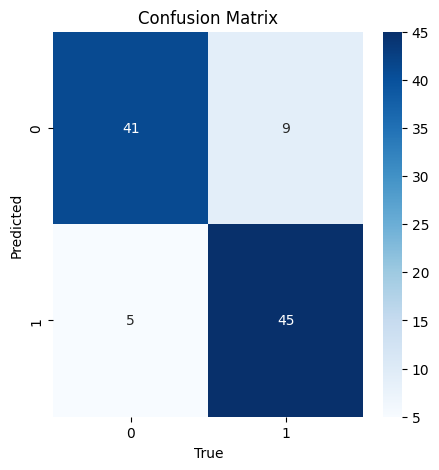

In [14]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

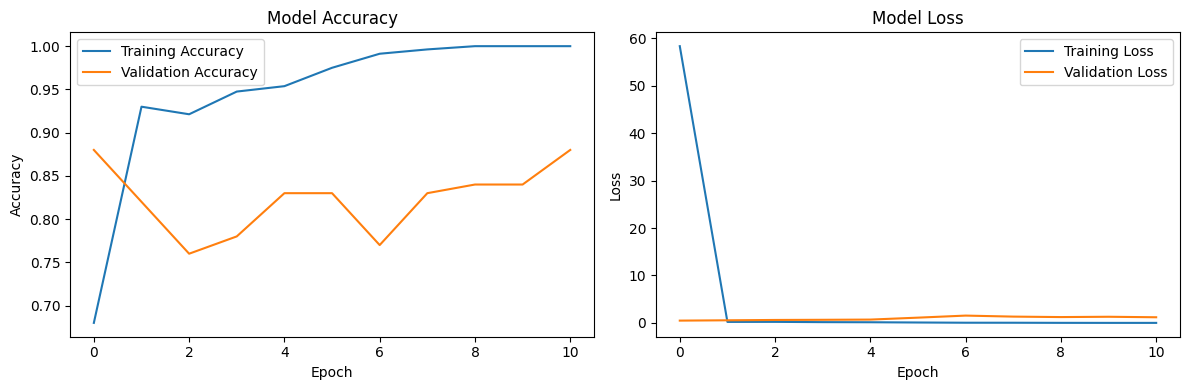

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Inception 모델은 channel value가 3이어야 함(rgb)
# 데이터가 grayscale이라면? -> r,g,b 값에 모두 동일한 grayscale 값을 넣어주는 방법
def create_inceptionv3_model(input_shape):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    # include_top: 전이 학습
    # True: 시작부터 완전 연결 계층까지 그대로 가져다 사용
    # False: 그대로 사용하지 않겠다는 의미
    base_model.trainable = False

    # 완전 연결 계층(inference)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

### Inception data 처리
- channel 1 -> 3

In [ ]:
# 데이터 차원을 3차원으로 수정
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Inception용 전처리
X_train_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_train_rgb)
X_val_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_val_rgb)
X_test_preprocessed = tf.keras.applications.inception_v3.preprocess_input(X_test_rgb)

input_shape = (299,299,3)
model = create_inceptionv3_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_inception_model.h5', save_best_only=True)
]

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
history = model.fit(
    X_train_preprocessed, y_train, # train data
    validation_data=(X_val_preprocessed, y_val), # validation data
    epochs=50, # 반복 횟수
    batch_size=32,  # 배치 사이즈
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.7319 - accuracy: 0.7412

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 18s 353ms/step - loss: 0.7319 - accuracy: 0.7412 - val_loss: 0.2643 - val_accuracy: 0.8900
Epoch 2/50
25/25 [==============================] - 5s 192ms/step - loss: 0.2085 - accuracy: 0.9038 - val_loss: 0.2197 - val_accuracy: 0.9100
Epoch 3/50
25/25 [==============================] - 5s 197ms/step - loss: 0.1674 - accuracy: 0.9262 - val_loss: 0.2060 - val_accuracy: 0.9200
Epoch 4/50
25/25 [==============================] - 5s 188ms/step - loss: 0.1318 - accuracy: 0.9500 - val_loss: 0.1953 - val_accuracy: 0.9200
Epoch 5/50
25/25 [==============================] - 5s 187ms/step - loss: 0.1112 - accuracy: 0.9538 - val_loss: 0.1651 - val_accuracy: 0.9200
Epoch 6/50
25/25 [==============================] - 4s 169ms/step - loss: 0.1046 - accuracy: 0.9650 - val_loss: 0.2044 - val_accuracy: 0.9200
Epoch 7/50
25/25 [==============================] - 4s 149ms/step - loss: 0.0884 - accuracy: 0.9638 - val_loss: 0.2308 - val_accuracy: 0.9300
Epoch 8/50
25/25

In [ ]:
model = tf.keras.models.load_model('best_inception_model.h5')

In [ ]:
test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 [==============================] - 3s 113ms/step - loss: 0.1729 - accuracy: 0.9300
Test accuracy: 0.9300


4/4 [==============================] - 4s 144ms/step


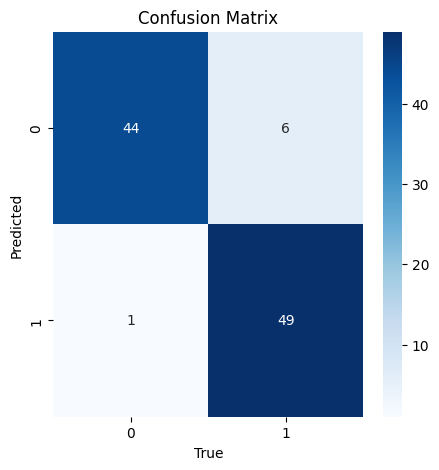

In [ ]:
y_pred = model.predict(X_test_preprocessed)
y_pred_classes = (y_pred>0.5).astype(int)

# confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

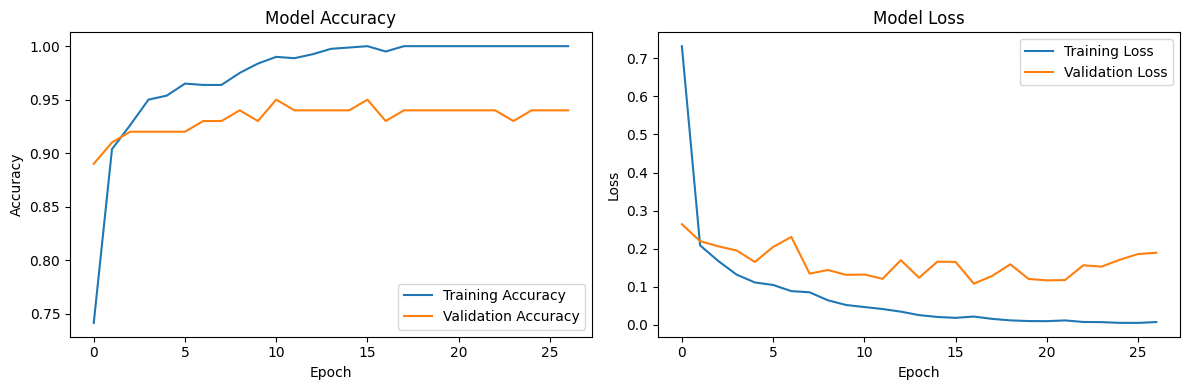

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

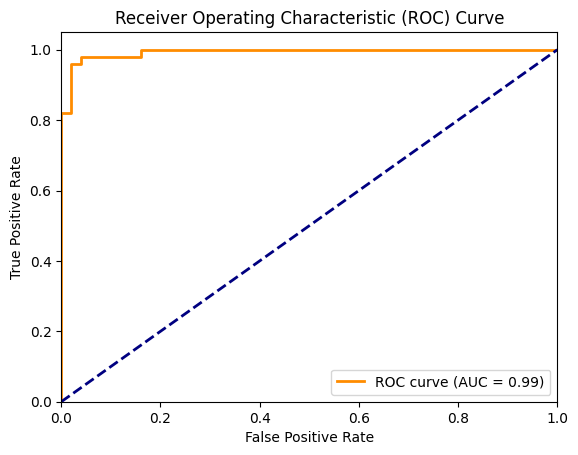

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()